# Coplanar waveguide setup and analysis

This example shows how to create a CPWG (coplanar waveguide with ground) design
in 2D Extractor and calculate the impedance.

Keywords: **Q2D**, **CPWG**, **Coplanar Waveguide**.

## Prerequisites

### Perform imports

In [1]:
import os
import tempfile
import time

import ansys.aedt.core

### Define constants
Constants help ensure consistency and avoid repetition throughout the example.

In [2]:
AEDT_VERSION = "2025.2"
NUM_CORES = 4
NG_MODE = False  # Run the example without opening the UI.

### Create temporary directory

Create a temporary working directory.
The name of the working folder is stored in ``temp_folder.name``.

> **Note:** The final cell in the notebook cleans up the temporary folder. If you want to
> retrieve the AEDT project and data, do so before executing the final cell in the notebook.

In [3]:
temp_folder = tempfile.TemporaryDirectory(suffix=".ansys")

### Launch AEDT

Launch an instance of the Ansys Electronics Desktop (AEDT) in graphical mode. 
The ``Q2d`` class inserts a 2-D Extractor design in AEDT. 

In [4]:
q2d = ansys.aedt.core.Q2d(
    version=AEDT_VERSION,
    non_graphical=NG_MODE,
    new_desktop=True,
    project=os.path.join(temp_folder.name, "cpwg"),
    design="coplanar_waveguide",
)

PyAEDT INFO: Python version 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)].


PyAEDT INFO: PyAEDT version 0.25.dev0.


PyAEDT INFO: Initializing new Desktop session.


PyAEDT INFO: Log on console is enabled.


PyAEDT INFO: Log on file C:\Users\ansys\AppData\Local\Temp\pyaedt_ansys_7c8c4d0c-883b-4ca8-9f40-77860e613296.log is enabled.


PyAEDT INFO: Log on AEDT is disabled.


PyAEDT INFO: Starting new AEDT gRPC session.


PyAEDT INFO: AEDT installation Path C:\Program Files\ANSYS Inc\v252\AnsysEM


PyAEDT INFO: Client application successfully started.


PyAEDT INFO: New AEDT gRPC session session started on port 50051.


PyAEDT INFO: 2025.2 version started with process ID 8916.


PyAEDT WARNING: Service Pack is not detected. PyAEDT is currently connecting in Insecure Mode.


PyAEDT WARNING: Please download and install latest Service Pack to use connect to AEDT in Secure Mode.


PyAEDT INFO: Debug logger is disabled. PyAEDT methods will not be logged.


PyAEDT INFO: Project cpwg has been created.


PyAEDT INFO: Added design 'coplanar_waveguide' of type 2D Extractor.


PyAEDT INFO: Aedt Objects correctly read


## Model Preparation

### Define parameters

Define independent parameters and create expressions that will
be used to create the
coplanar waveguide cross-section.

The dict ``cpw_params`` contains the independent parameters used to create
the model.

In [5]:
cpw_params = {
    "sig_bot_w": "150um",   # Signal conductor width - bottom.
    "e_factor": "2",        # Etch factor for trapezoidal cross-section.
    "gnd_w": "500um",       # Width of the ground conductor.
    "clearance": "150um",
    "cond_h": "50um",       # Conductor height
    "d_h": "150um",
    "sm_h": "20um",         # Solder mask height
    }

### Create expressions

Expressions are passed to the methods that we'll use to
create the geometric cross-section of the
coplanar waveguide. These expressions depend on the 
independent parameters defined in the previous cell, ``cpw_params``.

In [6]:
delta_w_half = "cond_h/e_factor"
sig_top_w = f"(sig_bot_w - 2 * {delta_w_half})"   # Signal top conductor width
co_gnd_top_w = f"(gnd_w - 2 * {delta_w_half})"    # Width of top ground conductor
model_w = "2 * gnd_w + 2 * clearance + sig_bot_w" # Total width of the model.

The following expressions define layer thicknesses parameterization.

In [7]:
layer_1_lh = 0
layer_1_uh = "cond_h"
layer_2_lh = layer_1_uh + " + d_h"
layer_2_uh = layer_2_lh + " + cond_h"

Assign independent parameters in the Q2d design.

In [8]:
for name, value in cpw_params.items():
    q2d[name] = value

Create the signal conductor by drawing two lines and connecting them to 
create a 2D sheet.

In [9]:
base_line_obj = q2d.modeler.create_polyline(
    points=[[0, layer_2_lh, 0], ["sig_bot_w", layer_2_lh, 0]], name="signal"
)

top_line_obj = q2d.modeler.create_polyline(
    points=[[0, layer_2_uh, 0], [sig_top_w, layer_2_uh, 0]]
)

q2d.modeler.move(assignment=[top_line_obj], vector=[delta_w_half, 0, 0])

q2d.modeler.connect([base_line_obj, top_line_obj])
q2d.modeler.move(
    assignment=[base_line_obj], vector=["gnd_w+clearance", 0, 0]
)

PyAEDT INFO: Modeler2D class has been initialized!


PyAEDT INFO: Modeler class has been initialized! Elapsed time: 0m 1sec


PyAEDT INFO: Materials class has been initialized! Elapsed time: 0m 0sec


PyAEDT INFO: Parsing design objects. This operation can take time


PyAEDT INFO: Refreshing bodies from Object Info


PyAEDT INFO: Bodies Info Refreshed Elapsed time: 0m 0sec


PyAEDT INFO: 3D Modeler objects parsed. Elapsed time: 0m 0sec


PyAEDT INFO: Connection Correctly created


True

Create adjacent ground layers.

In [10]:
base_line_obj = q2d.modeler.create_polyline(
    points=[[0, layer_2_lh, 0], ["gnd_w", layer_2_lh, 0]], name="co_gnd_left"
)

top_line_obj = q2d.modeler.create_polyline(
    points=[[0, layer_2_uh, 0], [co_gnd_top_w, layer_2_uh, 0]]
)

q2d.modeler.move(assignment=[top_line_obj], vector=[delta_w_half, 0, 0])
q2d.modeler.connect([base_line_obj, top_line_obj])

base_line_obj = q2d.modeler.create_polyline(
    points=[[0, layer_2_lh, 0], ["gnd_w", layer_2_lh, 0]], name="co_gnd_right"
)

top_line_obj = q2d.modeler.create_polyline(
    points=[[0, layer_2_uh, 0], [co_gnd_top_w, layer_2_uh, 0]]
)

q2d.modeler.move(assignment=[top_line_obj], vector=[delta_w_half, 0, 0])
q2d.modeler.connect([base_line_obj, top_line_obj])
q2d.modeler.move(
    assignment=[base_line_obj],
    vector=[f"gnd_w+clearance*2+sig_bot_w", 0, 0],
)

PyAEDT INFO: Parsing design objects. This operation can take time


PyAEDT INFO: Refreshing bodies from Object Info


PyAEDT INFO: Bodies Info Refreshed Elapsed time: 0m 0sec


PyAEDT INFO: 3D Modeler objects parsed. Elapsed time: 0m 0sec


PyAEDT INFO: Connection Correctly created


PyAEDT INFO: Parsing design objects. This operation can take time


PyAEDT INFO: Refreshing bodies from Object Info


PyAEDT INFO: Bodies Info Refreshed Elapsed time: 0m 0sec


PyAEDT INFO: 3D Modeler objects parsed. Elapsed time: 0m 0sec


PyAEDT INFO: Connection Correctly created


True

Create a reference ground plane.

In [11]:
q2d.modeler.create_rectangle(
    origin=[0, layer_1_lh, 0], sizes=[model_w, "cond_h"], name="ref_gnd"
)

ref_gnd

Define the substrate.

In [12]:
q2d.modeler.create_rectangle(
    origin=[0, layer_1_uh, 0],
    sizes=[model_w, "d_h"],
    name="Dielectric",
    material="FR4_epoxy",
)

Dielectric

Assign a conformal coating.

In [13]:
sm_obj_list = []
ids = [0, 1, 2]

if AEDT_VERSION < "2023.1":  # Support old versions of AEDT.
    ids = [1, 2, 3]

for obj_name in ["signal", "co_gnd_left", "co_gnd_right"]:
    obj = q2d.modeler.get_object_from_name(obj_name)
    e_obj_list = []
    for i in ids:
        e_obj = q2d.modeler.create_object_from_edge(obj.edges[i])
        e_obj_list.append(e_obj)
    e_obj_1 = e_obj_list[0]
    q2d.modeler.unite(e_obj_list)
    _ = q2d.modeler.sweep_along_vector(
        assignment=e_obj_1.id, sweep_vector=[0, "sm_h", 0]
    )
    sm_obj_list.append(e_obj_1)

new_obj = q2d.modeler.create_rectangle(
    origin=["gnd_w", layer_2_lh, 0], sizes=["clearance", "sm_h"]
)
sm_obj_list.append(new_obj)

new_obj2 = q2d.modeler.create_rectangle(
    origin=["gnd_w", layer_2_lh, 0], sizes=["clearance", "sm_h"]
)
q2d.modeler.move(assignment=[new_obj2], vector=["sig_bot_w+clearance", 0, 0])
sm_obj_list.append(new_obj2)

sm_obj = sm_obj_list[0]
q2d.modeler.unite(sm_obj_list)
sm_obj.material_name = "SolderMask"
sm_obj.color = (0, 150, 100)
sm_obj.name = "solder_mask"

PyAEDT INFO: Parsing design objects. This operation can take time


PyAEDT INFO: Refreshing bodies from Object Info


PyAEDT INFO: Bodies Info Refreshed Elapsed time: 0m 0sec


PyAEDT INFO: 3D Modeler objects parsed. Elapsed time: 0m 0sec


PyAEDT INFO: Union of 3 objects has been executed.


PyAEDT INFO: Parsing design objects. This operation can take time


PyAEDT INFO: Refreshing bodies from Object Info


PyAEDT INFO: Bodies Info Refreshed Elapsed time: 0m 0sec


PyAEDT INFO: 3D Modeler objects parsed. Elapsed time: 0m 0sec


PyAEDT INFO: Union of 3 objects has been executed.


PyAEDT INFO: Parsing design objects. This operation can take time


PyAEDT INFO: Refreshing bodies from Object Info


PyAEDT INFO: Bodies Info Refreshed Elapsed time: 0m 0sec


PyAEDT INFO: 3D Modeler objects parsed. Elapsed time: 0m 0sec


PyAEDT INFO: Union of 3 objects has been executed.


PyAEDT INFO: Parsing design objects. This operation can take time


PyAEDT INFO: Refreshing bodies from Object Info


PyAEDT INFO: Bodies Info Refreshed Elapsed time: 0m 0sec


PyAEDT INFO: 3D Modeler objects parsed. Elapsed time: 0m 0sec


PyAEDT INFO: Union of 5 objects has been executed.


### Assign sources and boundary conditions

Define the signal conductor.

In [14]:
signal_conductor = q2d.modeler.get_object_from_name("signal")
q2d.assign_single_conductor(
    name=signal_conductor.name,
    assignment=[signal_conductor],
    conductor_type="SignalLine",
    solve_option="SolveOnBoundary",
    units="mm",
)

PyAEDT INFO: Boundary SignalLine signal has been created.


signal

Assign the Huray model for conductive losses on the signal trace.

In [15]:
q2d.assign_huray_finitecond_to_edges(signal_conductor.edges, 
                                     radius="0.5um", 
                                     ratio=3, 
                                     name="b_" + signal_conductor.name
                                     )

PyAEDT INFO: Boundary Finite Conductivity b_signal has been created.


b_signal

Define the return path.

In [16]:
reference_conductors = [q2d.modeler.get_object_from_name(i)
                     for i in ["co_gnd_left", "co_gnd_right", "ref_gnd"]
                    ]

q2d.assign_single_conductor(
    name="gnd",
    assignment=reference_conductors,
    conductor_type="ReferenceGround",
    solve_option="SolveOnBoundary",
    units="mm",
)

PyAEDT INFO: Boundary ReferenceGround gnd has been created.


gnd

### Define solution setup

The solution steup specifies the frequency range for the solution and other 
solution settings

In [17]:
setup = q2d.create_setup(setupname="new_setup")

sweep = setup.add_sweep(name="sweep1")
sweep.props["RangeType"] = "LinearStep"
sweep.props["RangeStart"] = "1GHz"
sweep.props["RangeStep"] = "100MHz"
sweep.props["RangeEnd"] = "5GHz"
sweep.props["SaveFields"] = False
sweep.props["SaveRadFields"] = False
sweep.props["Type"] = "Interpolating"

sweep.update()

PyAEDT INFO: Key setupname matched internal key 'Name' with confidence of 46.


PyAEDT INFO: Parsing C:\Users\ansys\AppData\Local\Temp\tmpgn2f5sio.ansys\cpwg.aedt.


PyAEDT INFO: File C:\Users\ansys\AppData\Local\Temp\tmpgn2f5sio.ansys\cpwg.aedt correctly loaded. Elapsed time: 0m 0sec


PyAEDT INFO: aedt file load time 0.015951871871948242


True

### Run analysis

In [18]:
q2d.analyze(cores=NUM_CORES)

PyAEDT INFO: Project cpwg Saved correctly


PyAEDT INFO: Key Desktop/ActiveDSOConfigurations/2D Extractor correctly changed.


PyAEDT INFO: Solving all design setups. Analysis started...


PyAEDT INFO: Design setup None solved correctly in 0.0h 0.0m 21.0s


PyAEDT INFO: Key Desktop/ActiveDSOConfigurations/2D Extractor correctly changed.


True

## Postprocess

View the impedance over frequency.

PyAEDT INFO: Parsing C:\Users\ansys\AppData\Local\Temp\tmpgn2f5sio.ansys\cpwg.aedt.


PyAEDT INFO: File C:\Users\ansys\AppData\Local\Temp\tmpgn2f5sio.ansys\cpwg.aedt correctly loaded. Elapsed time: 0m 0sec


PyAEDT INFO: aedt file load time 0.04723167419433594


PyAEDT INFO: PostProcessor class has been initialized! Elapsed time: 0m 0sec


PyAEDT INFO: Post class has been initialized! Elapsed time: 0m 0sec


PyAEDT WARNING: No report category provided. Automatically identified Matrix


PyAEDT INFO: Solution Data Correctly Loaded.


Time to initialize solution data:0.016065359115600586
Time to initialize solution data:0.016065359115600586


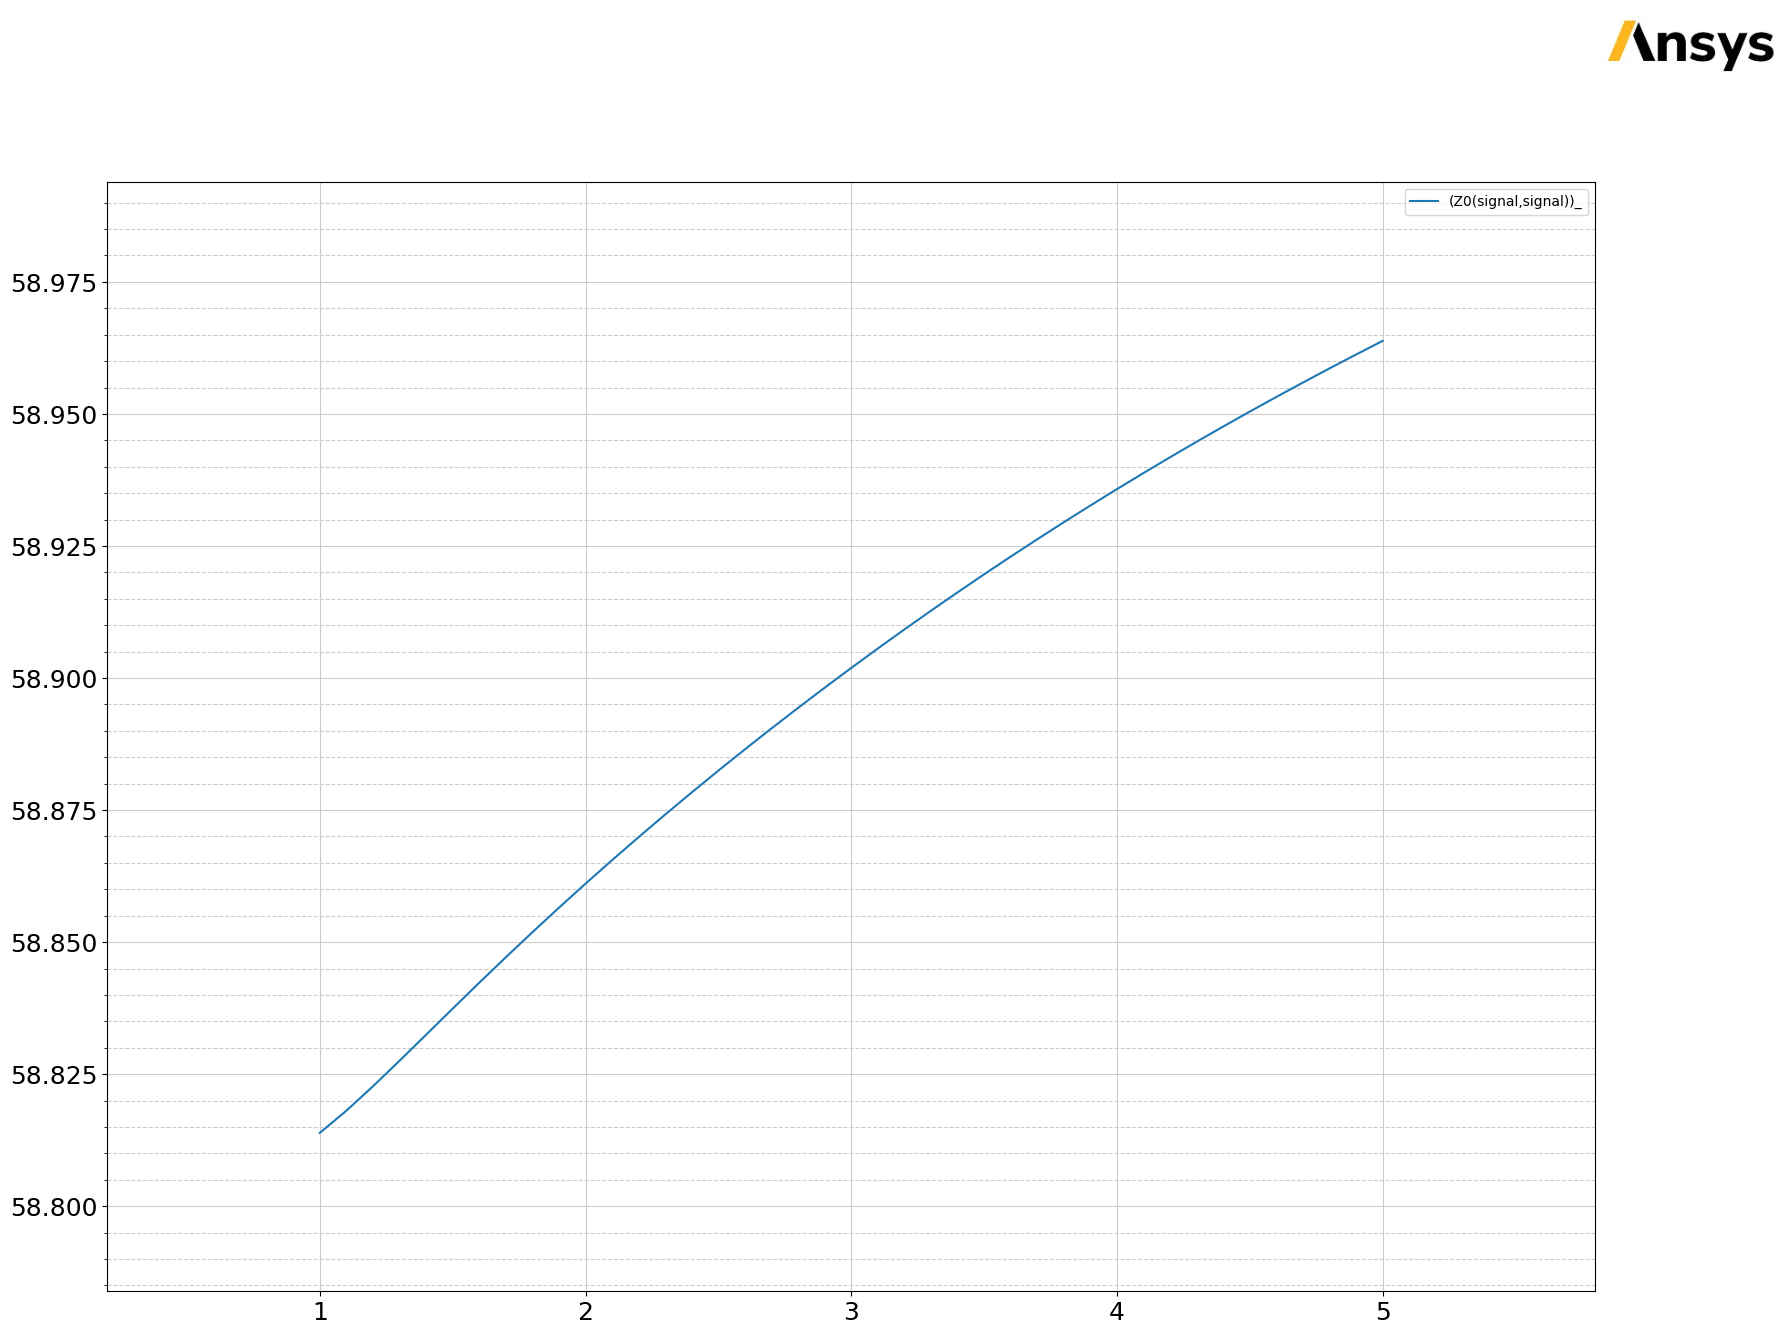

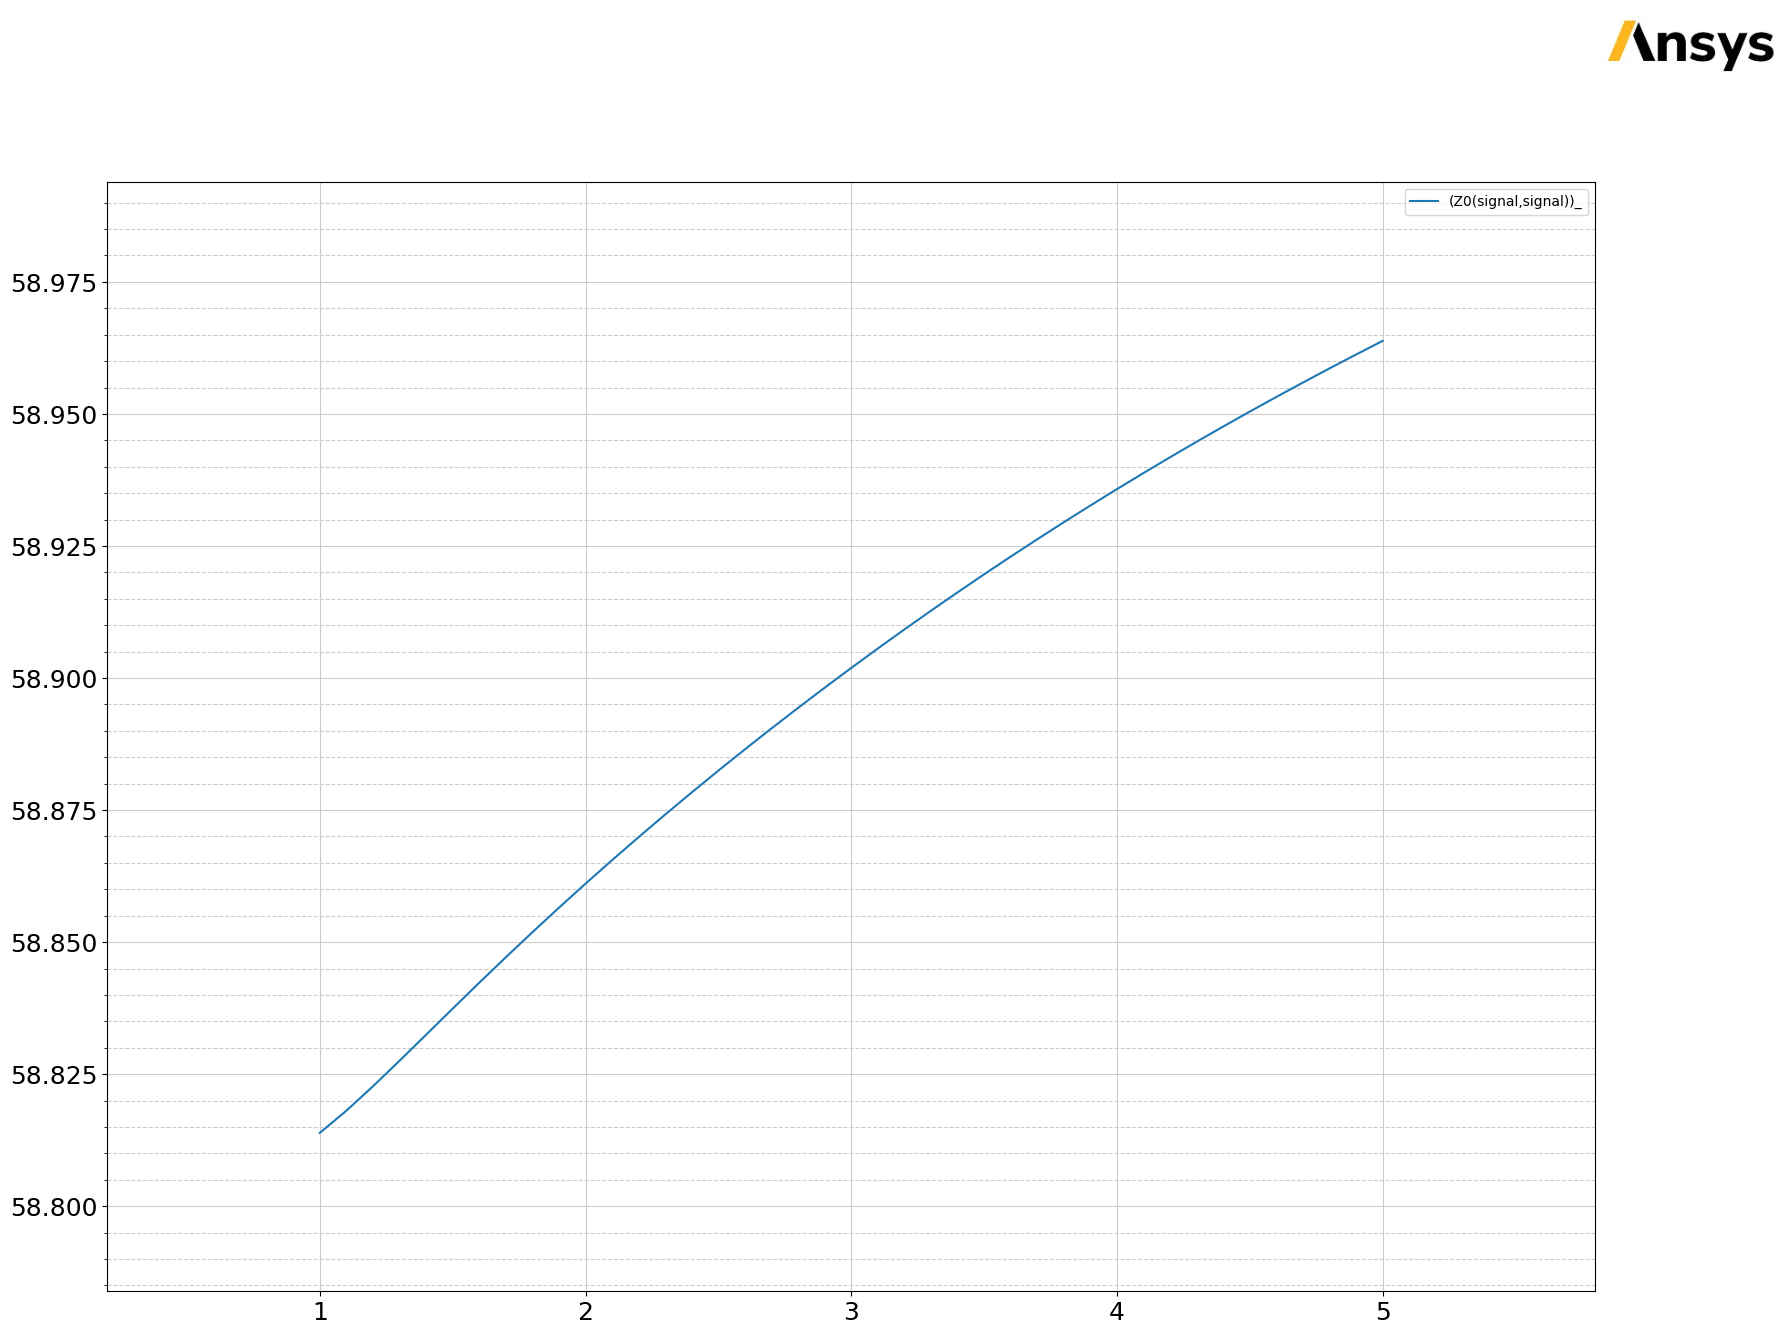

In [19]:
data = q2d.post.get_solution_data(expressions="Z0(signal,signal)", context="Original")
data.plot()

## Finish

### Save the project

In [20]:
q2d.save_project()
q2d.release_desktop()
# Wait 3 seconds to allow AEDT to shut down before cleaning the temporary directory.
time.sleep(3)

PyAEDT INFO: Project cpwg Saved correctly


PyAEDT INFO: Desktop has been released and closed.


### Clean up

All project files are saved in the folder ``temp_folder.name``.
If you've run this example as a Jupyter notebook, you
can retrieve those project files. The following cell
removes all temporary files, including the project folder.

In [21]:
temp_folder.cleanup()